### Hyperparameter Optimized Logistic Regression

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
from pathlib import Path
import pandas as pd

# Ensure you have created a "data" folder in your project directory 
# and downloaded the CSV file inside it.
file_path = Path.cwd().parent / "data" / "athens_weather_df_2019_2023.csv"

# Load dataset with index and date parsing
lagged_1h_df = pd.read_csv(file_path, parse_dates=["date"])

In [4]:
import pickle

# Load the list of variables to transform
variables_to_transform_path = "../data/variables_to_transform.pkl"

with open(variables_to_transform_path, "rb") as f:
    variables_to_transform = pickle.load(f)

print(variables_to_transform)

['direct_radiation_lag_1h', 'cloud_cover_mid_lag_1h', 'cloud_cover_low_lag_1h', 'vapour_pressure_deficit_lag_1h', 'evapotranspiration_lag_1h']


So far, each iteration has improved the baseline model. However, performance remains similar across iterations, with minor variations. 

What if we try to fine tune the model?   
In the arguments of `LogisticRegression` there is a hyperparameter C corresponding to the inverse of regularization strength, to control a possible overfit of the model to the data, and where smaller values specify stronger regularization. It can take any real value in an interval like from 1e-3 up to 100 for example. A fine tuning process consists in essence in finding the best value for this hyperparameter that yields the best performance with respect to the metric of our choice. We can check manually this range of numbers and review the results, but this can take several days...

There is a more effective way to search for all possible combinations using **[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)**, where you manually define the parameter space, and the method will take over, creating and exploring all possible combinations *(or values if it is for a single hyperparameter)* for you, evaluating the model based on a specified evaluation metric, and return the best model along with its set of optimal parameters.   
It is important to note that GridSearchCV accepts only discrete values for each parameter defined by the user. If for example you need to tune 3 hyperparameters each taking 5 possible/distinct values, this will result in **$5^3=125$** combinations and for a 10-fold cross-validation this will result in fitting 1250 models, making the method computationally expensive and often impractical for larger search spaces.

There is an alternative method called **[RandomizedSearchCV](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)**, which speeds up the process by randomly selecting values from the parameter space you have defined. You specify how many combinations should be evaluated by setting the `n_iter` argument. The method evaluates these combinations and returns the best model along with its corresponding parameters. This approach significantly reduces the computational time but does not guarantee that it will find the absolute best model, given the dataset and parameter space at hand.

In this section, we will use another method called **[BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)**, which exploits Bayesian optimization. This method intelligently searches the hyperparameter space using a probabilistic model to guide the search, making it more efficient than traditional methods like `GridSearchCV` and `RandomizedSearchCV`.

The process begins by defining the hyperparameter search space. Initially, BayesSearchCV performs a small number of random evaluations by selecting different combinations of hyperparameters. These initial evaluations explore diverse regions of the parameter space to gather data. Based on this data, the algorithm builds a probabilistic model, which helps predict which areas of the hyperparameter space are most likely to contain optimal combinations.

This approach significantly reduces the number of hyperparameter combinations that need to be evaluated, making it much more efficient. The best model and its optimal hyperparameter settings are returned after evaluating all combinations.
Even though this method is much more efficient, there’s a degree of randomness in the cross-validation process and in the initial random samples selected during the BayesSearchCV process. This might cause optimization to focus on suboptimal areas of the hyperparameter space and it does not guarantee that you will indeed end up with the best possible model settings. An increase on the n_iter argument (the number of parameter combinations) can help in this direction but it will also increase the computational cost. Experience also will be valuable since you can restrict the hyperparameter space if you already know where the best possible combination might lie and this can be set by defining the prior distribution in the prior argument of each parameter you aim to search for, and optimize.

<u>Key points on BayesSearchCV</u>
- The n_iter argument is specified by the user when calling BayesSearchCV(). After setting this parameter, the user no longer controls how the algorithm selects combinations within the search space. For example, if n_iter=30, the algorithm will evaluate 30 different hyperparameter combinations in total. Initially, a small number of combinations are randomly selected and evaluated. Based on these initial evaluations, the algorithm builds a probabilistic model, which it then uses to guide the remaining iterations, focusing on combinations that are predicted to yield better performance. The best model from all 30 evaluations is returned as the final model.
- Increasing the n_iter argument, increases your chances of finding the best possible model, but at the same time you are also increasing your computational costs (time and resources)
- Initially, BayesSearchCV performs a few random evaluations of hyperparameter combinations (the rest combinations will be used after the probabilistic model is built). These initial samples are influenced by the **`prior`** distribution that we define for each parameter (e.g., `log-uniform` for `C`). The prior distribution represents our **initial belief** about where the best hyperparameters might lie.
- In this phase, random hyperparameter values are sampled from the defined search space, but the **`prior`** (e.g., `log-uniform`) influences the frequency with which different values are selected. For example, if you're using 'log-uniform' for the hyperparameter'C', smaller values will be sampled more often than larger values, because this is your <u>initial/prior</u> belief of where the best parameter values might lie.
- If your initial guess/belief about the prior distribution for sampling values is incorrect, don't worry. This will be reflected in the probabilistic model built by the algorithm, based on the poor performance of the models built using that prior. These poor results will prompt the algorithm to adapt and guide the search towards more promising ranges. Therefore, it is the range of the parameter values that you should be careful not to restrict. An incorrect initial prior probability will not prevent the algorithm from finding good solutions, as it will adjust during the search.
- After evaluating the initial random samples, BayesSearchCV builds a **probabilistic model**. This model then uses the updated probabilities distribution (*posterior distribution*), which is the updated belief about where the best hyperparameters might lie after incorporating the results of the initial evaluations.
- From this point, the **posterior distribution** is used to guide the search. The algorithm no longer selects hyperparameters randomly; instead, it uses the posterior distribution to focus the search on areas of the hyperparameter space that are predicted to perform better.

**Last important note**   
While BayesSearchCV is more effective than traditional methods at exploring and exploiting the hyperparameter space, it still cannot guarantee the optimal set of parameters—and thus the best possible model-, <u>**due to its probabilistic nature**.</u>   

For more information on the BayesSearchCV, please refer to the following links:   
https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html   
and   
https://deephyper.readthedocs.io/en/latest/_autosummary/deephyper.skopt.BayesSearchCV.html

**Before running the script below, ensure that you have run the following:     
`pip install scikit-optimize`**

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

import time

# Define features (X) and target (y)
X = lagged_1h_df.drop(columns=['date', 'weather_event'])
y = lagged_1h_df['weather_event']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Define the preprocessing step for Yeo-Johnson transformation
preprocessor = ColumnTransformer([
    ('yeo_johnson', PowerTransformer(method='yeo-johnson'), variables_to_transform),
], remainder='passthrough')  # Leave other features untouched

# Define the pipeline
bayes_pipeline = Pipeline([
    ('preprocessing', preprocessor),   # Step 1: Yeo-Johnson transformation for specific variables
    ('scaling', RobustScaler()),       # Step 2: Scale all features
    ('bayes_model', OneVsRestClassifier(LogisticRegression(
        class_weight='balanced',
        max_iter=1500,
        random_state=42,
        n_jobs=-1
    )))
])

param_space = {
    'bayes_model__estimator__C': Real(1e-1, 10, prior='log-uniform'),  # Regularization strength
    'bayes_model__estimator__solver': Categorical(['lbfgs', 'newton-cg'])  # Optimization solver
}

# Stratified k-fold cross-validation
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# BayesSearchCV for hyperparameter tuning
bayes_search = BayesSearchCV(
    estimator=bayes_pipeline,
    search_spaces=param_space,
    n_iter=50,  # Number of parameter combinations to evaluate
    scoring='balanced_accuracy',
    cv=stkf,
    random_state=42,
    n_jobs=-1
)

# Fit BayesSearchCV to the training data
import time
start = time.time()
bayes_search.fit(X_train, y_train)
execution_time = time.time() - start

# Output results
print("Best parameters found")
bayes_search.best_params_
print("Best cross-validation score")
bayes_search.best_score_
print(f"Execution time: {execution_time:.2f} seconds")

# Extract and save detailed results
results_df = pd.DataFrame(bayes_search.cv_results_)

BayesSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('preprocessing',
                                         ColumnTransformer(remainder='passthrough',
                                                           transformers=[('yeo_johnson',
                                                                          PowerTransformer(),
                                                                          ['direct_radiation_lag_1h',
                                                                           'cloud_cover_mid_lag_1h',
                                                                           'cloud_cover_low_lag_1h',
                                                                           'vapour_pressure_deficit_lag_1h',
                                                                           'evapotranspiration_lag_1h'])]))...
                                         OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                                          max_iter=1500,
                                                                                          n_jobs=-1,
                                                                                          random_state=42)))]),
              n_jobs=-1, random_state=42, scoring='balanced_accuracy',
              search_spaces={'bayes_model__estimator__C': Real(low=0.1, high=10, prior='log-uniform', transform='normalize'),
                             'bayes_model__estimator__solver': Categorical(categories=('lbfgs', 'newton-cg'), prior=None)})

Best parameters found


OrderedDict([('bayes_model__estimator__C', 2.1273464184336186),
             ('bayes_model__estimator__solver', 'newton-cg')])

Best cross-validation score


0.9080388510351793

Execution time: 68.75 seconds


In [7]:
bayes_best_model = bayes_search.best_estimator_
bayes_best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('yeo_johnson',
                                                  PowerTransformer(),
                                                  ['direct_radiation_lag_1h',
                                                   'cloud_cover_mid_lag_1h',
                                                   'cloud_cover_low_lag_1h',
                                                   'vapour_pressure_deficit_lag_1h',
                                                   'evapotranspiration_lag_1h'])])),
                ('scaling', RobustScaler()),
                ('bayes_model',
                 OneVsRestClassifier(estimator=LogisticRegression(C=2.1273464184336186,
                                                                  class_weight='balanced',
                                                                  max_iter=1500,
                                                                  n_jobs=-1,
                                                                  random_state=42,
                                                                  solver='newton-cg')))])

In [8]:
y_pred_bayes_grid = bayes_best_model.predict(X_test)

#### **Model Evaluation**

##### **The Confusion Matrix**

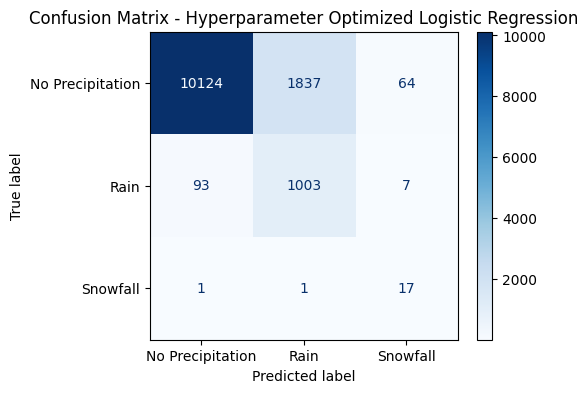

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 4))
conf_matrix_bayes_grid = confusion_matrix(y_test, y_pred_bayes_grid)
disp = ConfusionMatrixDisplay(conf_matrix_bayes_grid, display_labels=['No Precipitation', 'Rain', 'Snowfall'])
plot = disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
title = plt.title('Confusion Matrix - Hyperparameter Optimized Logistic Regression')
plt.show()

- save the confusion matrix

In [10]:
from joblib import dump

# Define the file path
conf_matrix_path = "../reports/07_bayes_logistic_regression_confusion_matrix.joblib"

# Save the confusion matrix
dump(conf_matrix_bayes_grid, conf_matrix_path)

print(f"Hyperparameter Optimized (Bayes) Logistic Regression confusion matrix saved at: {conf_matrix_path}")

['../reports/07_bayes_logistic_regression_confusion_matrix.joblib']

Hyperparameter Optimized (Bayes) Logistic Regression confusion matrix saved at: ../reports/07_bayes_logistic_regression_confusion_matrix.joblib


##### **The Precision-Recall Curve**

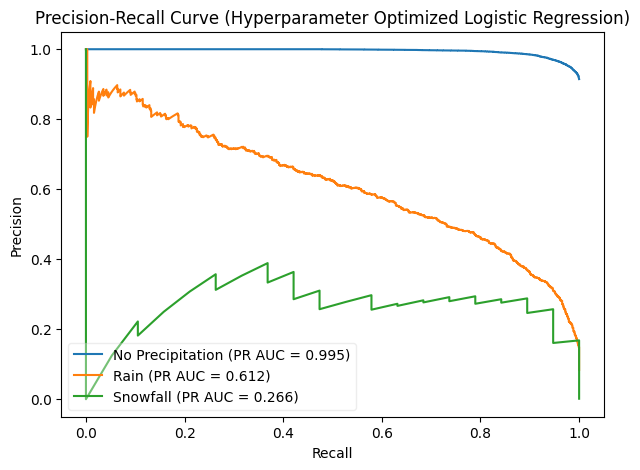

In [11]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Generate precision-recall curve for each class
y_pred_probs_bayes_grid = bayes_best_model.predict_proba(X_test)

# Class labels
class_labels = ['No Precipitation', 'Rain', 'Snowfall']

# Initialize plot
figure = plt.figure(figsize=(7, 5))  
for i, label in enumerate(class_labels):  
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_probs_bayes_grid[:, i])
    pr_auc = auc(recall, precision)
    
    # Plot the precision-recall curve
    plot = plt.plot(recall, precision, label=f'{label} (PR AUC = {pr_auc:.3f})')

xlabel = plt.xlabel('Recall')
ylabel = plt.ylabel('Precision')
title = plt.title('Precision-Recall Curve (Hyperparameter Optimized Logistic Regression)')
legend = plt.legend(loc='lower left', framealpha=0.35)
plt.show()

##### **The Classification Report**

In [12]:
from sklearn.metrics import (
    classification_report, balanced_accuracy_score, f1_score, 
    average_precision_score, precision_recall_curve, auc
)

# Classification report
report_dict_grid = classification_report(y_test, y_pred_bayes_grid, digits=3, output_dict=True)

# Calculate PR AUC for each class
precision_0, recall_0, _ = precision_recall_curve(y_test == 0, y_pred_probs_bayes_grid[:, 0])
pr_auc_0 = auc(recall_0, precision_0)

precision_rain, recall_rain, _ = precision_recall_curve(y_test == 1, y_pred_probs_bayes_grid[:, 1])
pr_auc_rain = auc(recall_rain, precision_rain)

precision_snow, recall_snow, _ = precision_recall_curve(y_test == 2, y_pred_probs_bayes_grid[:, 2])
pr_auc_snow = auc(recall_snow, precision_snow)
# Create a single row dataframe with the required metrics
report_df_bayes_grid = pd.DataFrame({
    'precision_0': [report_dict_grid['0']['precision']],
    'recall_0': [report_dict_grid['0']['recall']],
    'f1_0': [report_dict_grid['0']['f1-score']],
    'pr_auc_0': [pr_auc_0],
    
    'precision_rain': [report_dict_grid['1']['precision']],
    'recall_rain': [report_dict_grid['1']['recall']],
    'f1_rain': [report_dict_grid['1']['f1-score']],
    'pr_auc_rain': [pr_auc_rain],
    
    'precision_snow': [report_dict_grid['2']['precision']],
    'recall_snow': [report_dict_grid['2']['recall']],
    'f1_snow': [report_dict_grid['2']['f1-score']],
    'pr_auc_snow': [pr_auc_snow],
    'balanced_accuracy': [balanced_accuracy_score(y_test, y_pred_bayes_grid)],
    'f1_macro': [f1_score(y_test, y_pred_bayes_grid, average='macro')],
    'pr_auc_macro': [average_precision_score(y_test, y_pred_probs_bayes_grid, average='macro')]

})

# Display the DataFrame
print('Hyperparameter Optimized Logistic Regression')
report_df_bayes_grid = report_df_bayes_grid.round(4)
report_df_bayes_grid

Hyperparameter Optimized Logistic Regression


,precision_0,recall_0,f1_0,pr_auc_0,precision_rain,recall_rain,f1_rain,pr_auc_rain,precision_snow,recall_snow,f1_snow,pr_auc_snow,balanced_accuracy,f1_macro,pr_auc_macro
0,0.9908,0.8419,0.9103,0.9948,0.353,0.9093,0.5086,0.6125,0.1932,0.8947,0.3178,0.2661,0.882,0.5789,0.6305


- save the metrics report

In [13]:
# Define the file path
report_path = "../reports/07_bayes_logistic_regression_report.joblib"

# Save the report DataFrame
dump(report_df_bayes_grid, report_path)

print(f"Hyperparameter Optimized (Bayes) Logistic Regression report saved at: {report_path}")

['../reports/07_bayes_logistic_regression_report.joblib']

Hyperparameter Optimized (Bayes) Logistic Regression report saved at: ../reports/07_bayes_logistic_regression_report.joblib


##### **The learning curve**

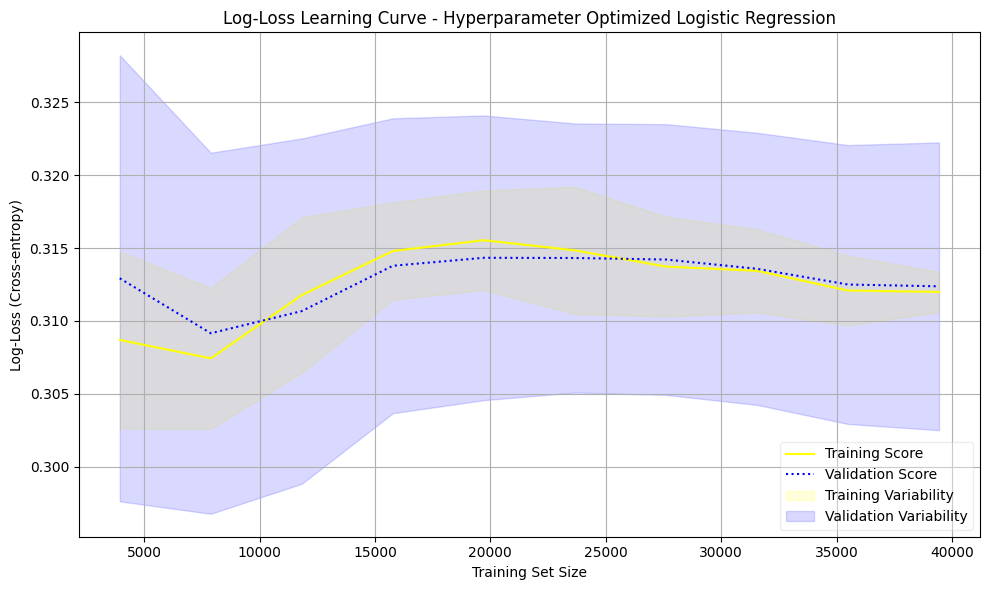

In [14]:
import numpy as np
from sklearn.model_selection import learning_curve
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    bayes_best_model, X, y, cv=stkf, scoring='neg_log_loss', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
)

train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

figure = plt.figure(figsize=(10, 6))
plot1 = plt.plot(train_sizes, train_mean, label='Training Score', color='yellow')
plot2 = plt.plot(train_sizes, test_mean, label='Validation Score', color='blue', linestyle=':')
ce1_fill = plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='yellow', 
                            alpha=0.15, label='Training Variability')
ce2_fill = plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='blue', 
                            alpha=0.15, label='Validation Variability')

xlabel = plt.xlabel('Training Set Size')
ylabel = plt.ylabel('Log-Loss (Cross-entropy)')
title = plt.title('Log-Loss Learning Curve - Hyperparameter Optimized Logistic Regression')
legend = plt.legend(loc='lower right', framealpha=0.35)
grid = plt.grid(True)
plt.tight_layout()
plt.show()

<u>Inferences from the Learning Curve Plot</u>   

The log-loss learning curve for the Bayesian-optimized logistic regression model converges to approximately 0.313 for both the training and validation sets when the full dataset is used. The two curves remain closely aligned throughout the plot, indicating that the model does not overfit and maintains stable generalization performance across different training sizes.

Compared to the previous iterations, no commendable improvement was noticed, indicating that hyperparameter tuning alone did not lead to substantial improvements.

Both lines as the full dataset is fed into the model appear to plateau suggesting that further improvements from additional data are unlikely.

Despite the benefits of Bayesian optimization, the validation variability (blue shaded region) remains relatively high, suggesting that the model’s performance on unseen data is still inconsistent.   

The results strongly indicate that further improvements using the Logistic Regression algorithm **alone** are highly unlikely.

This could be due to several factors:
- **Complex, potentially non-linear relationships among the predictors that Logistic Regression fails to capture.**
- **Severe class imbalance, which continues to impact performance despite various balancing strategies.**
- **The algorithm may have reached its full potential given the constraints of this dataset.**

**Save the Trained Model**

In [15]:
# Define the file path
model_path = "../models/bayes_logistic_regression.joblib"

# Save the entire pipeline
dump(bayes_best_model, model_path)

print(f"Hyperparameter Optimized (Bayes) Logistic Regression model saved at: {model_path}")

['../models/bayes_logistic_regression.joblib']

Hyperparameter Optimized (Bayes) Logistic Regression model saved at: ../models/bayes_logistic_regression.joblib
